In [194]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tqdm import tqdm
import os

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [195]:
df_train = pd.read_csv("../input/train.csv", names = ["Label", "Headline", "Description"])
df_test = pd.read_csv("../input/test.csv", names = ["Label", "Headline", "Description"])

In [196]:
df_train_label =  df_train["Label"]
df_test_label =  df_test["Label"]

In [197]:
print(df_train["Label"].value_counts())
print(df_test["Label"].value_counts())

4    30000
3    30000
2    30000
1    30000
Name: Label, dtype: int64
3    1900
2    1900
1    1900
4    1900
Name: Label, dtype: int64


## **Text Preprocessing**

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [198]:
# printing some random Description
des_1 = df_train['Description'].values[51147]
print(des_1)
print("="*50)

des_2 = df_train['Description'].values[51151]
print(des_2)
print("="*50)

des_3 = df_train['Description'].values[51628]
print(des_3)
print("="*50)

des_4 = df_train['Description'].values[51867]
print(des_4)
print("="*50)

Reuters - A former Enron Corp.  \assistant treasurer pleaded guilty on Tuesday in U.S. District\Court to conspiracy to commit securities fraud for disguising\the company's weak finances before its dramatic collapse.
 SAN FRANCISCO (Reuters) - A PeopleSoft Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=PSFT.O target=/stocks/quickinfo/fullquote"&gt;PSFT.O&lt;/A&gt; board  member told a Delaware court on Tuesday that the software maker  would consider a bid from its rival Oracle Corp. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=ORCL.O target=/stocks/quickinfo/fullquote"&gt;ORCL.O&lt;/A&gt;  provided the price was right and a deal closed quickly.
 NEW YORK (Reuters) - U.S. stocks were set to open flat on  Wednesday as high crude oil prices and profit warnings weighed  on the market on the eve of a new earnings reporting season.
 WASHINGTON (Reuters) - The United States and Europe on  Wednesday filed tit-for-tat World Trade Organization complain

### **1. Removing url**

In [199]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
des_1 = re.sub(r"http\S+", "", des_1)
des_2 = re.sub(r"http\S+", "", des_2)
des_3 = re.sub(r"http\S+", "", des_3)
des_4 = re.sub(r"http\S+", "", des_4)

print(des_2)

 SAN FRANCISCO (Reuters) - A PeopleSoft Inc. &lt;A HREF=" target=/stocks/quickinfo/fullquote"&gt;PSFT.O&lt;/A&gt; board  member told a Delaware court on Tuesday that the software maker  would consider a bid from its rival Oracle Corp. &lt;A HREF=" target=/stocks/quickinfo/fullquote"&gt;ORCL.O&lt;/A&gt;  provided the price was right and a deal closed quickly.


### **2. Removing tags**

In [200]:

from bs4 import BeautifulSoup

soup = BeautifulSoup(des_1, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(des_2, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(des_3, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(des_4, 'lxml')
text = soup.get_text()
print(text)

Reuters - A former Enron Corp.  \assistant treasurer pleaded guilty on Tuesday in U.S. District\Court to conspiracy to commit securities fraud for disguising\the company's weak finances before its dramatic collapse.
SAN FRANCISCO (Reuters) - A PeopleSoft Inc. <A HREF=" target=/stocks/quickinfo/fullquote">PSFT.O</A> board  member told a Delaware court on Tuesday that the software maker  would consider a bid from its rival Oracle Corp. <A HREF=" target=/stocks/quickinfo/fullquote">ORCL.O</A>  provided the price was right and a deal closed quickly.
NEW YORK (Reuters) - U.S. stocks were set to open flat on  Wednesday as high crude oil prices and profit warnings weighed  on the market on the eve of a new earnings reporting season.
WASHINGTON (Reuters) - The United States and Europe on  Wednesday filed tit-for-tat World Trade Organization complaints  over billions of dollars in subsidies for top aircraft  manufacturers Airbus and Boeing.


### **3. Exapanding english language**

In [201]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### **4. Removing special charachters and numbers**

In [202]:
#remove words with numbers python
des_1 = re.sub("\S*\d\S*", "", des_1).strip()
print(des_1)

Reuters - A former Enron Corp.  \assistant treasurer pleaded guilty on Tuesday in U.S. District\Court to conspiracy to commit securities fraud for disguising\the company's weak finances before its dramatic collapse.


In [203]:
#remove spacial character
des_1 = re.sub('[^A-Za-z0-9]+', ' ', des_1)
print(des_1)

Reuters A former Enron Corp assistant treasurer pleaded guilty on Tuesday in U S District Court to conspiracy to commit securities fraud for disguising the company s weak finances before its dramatic collapse 


### **5. Removing Stopwords**

In [204]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [205]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_description = []
# tqdm is for printing the status bar
for sentence in tqdm(df_train['Description'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_description.append(sentence.strip())



 29%|██▉       | 34734/120000 [00:13<00:33, 2565.07it/s]


 58%|█████▊    | 70194/120000 [00:27<00:19, 2526.24it/s]


 88%|████████▊ | 106176/120000 [00:41<00:05, 2612.60it/s]


100%|██████████| 120000/120000 [00:46<00:00, 2573.33it/s]

**Similarly we can do the preprocessiong for Headline**

In [206]:
from tqdm import tqdm
preprocessed_headline = []
# tqdm is for printing the status bar
for sentence in tqdm(df_train['Headline'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_headline.append(sentence.strip())


 35%|███▌      | 42334/120000 [00:13<00:24, 3137.38it/s]


 70%|███████   | 84418/120000 [00:28<00:11, 3074.55it/s]


100%|██████████| 120000/120000 [00:40<00:00, 2970.42it/s]

In [207]:
df_train_preprocessed = df_train
df_train_preprocessed['Label'] = df_train['Label']
df_train_preprocessed['Headline'] = preprocessed_headline
df_train_preprocessed['Description'] = preprocessed_description

In [208]:
df_train_preprocessed.head()

,Label,Headline,Description
0,3,wall st bears claw back black reuters,reuters short sellers wall street dwindling ba...
1,3,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle group ...
2,3,oil economy cloud stocks outlook reuters,reuters soaring crude prices plus worries econ...
3,3,iraq halts oil exports main southern pipeline ...,reuters authorities halted oil export flows ma...
4,3,oil prices soar time record posing new menace ...,afp tearaway world oil prices toppling records...


## Test set Preprocessing

In [209]:
#preprocessing for test set headlines
from tqdm import tqdm
preprocessed_headline_test = []
# tqdm is for printing the status bar
for sentence in tqdm(df_test['Headline'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_headline_test.append(sentence.strip())

#preprocessing for test set descriptions    
from tqdm import tqdm
preprocessed_description_test = []
# tqdm is for printing the status bar
for sentence in tqdm(df_test['Description'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_description_test.append(sentence.strip())


100%|██████████| 7600/7600 [00:02<00:00, 2557.94it/s]

In [210]:
df_test_preprocessed = df_test
df_test_preprocessed['Label'] = df_test['Label']
df_test_preprocessed['Headline'] = preprocessed_headline_test
df_test_preprocessed['Description'] = preprocessed_description_test

# **Logistic Regression Model**

## Bi-Grams and n-Grams
Simply,Converting a collection of text documents to a matrix of token counts

In [211]:
from sklearn import preprocessing

#removing stop words like "not" should be avoided before building n-grams
#Vectorizing the description
count_vect_description = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_des_train = count_vect_description.fit_transform(preprocessed_description)
#Normalize
final_bigram_des_train = preprocessing.normalize(final_bigram_des_train)

final_bigram_des_test = count_vect_description.transform(preprocessed_description_test)
#Normalize
final_bigram_des_test = preprocessing.normalize(final_bigram_des_test)

#Vectorizing the Headline
count_vect_headline = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_head_train = count_vect_headline.fit_transform(preprocessed_headline)
#Normalize
final_bigram_head_train = preprocessing.normalize(final_bigram_head_train)

final_bigram_head_test = count_vect_headline.transform(preprocessed_headline_test)
#Normalize
final_bigram_head_test = preprocessing.normalize(final_bigram_head_test)


Observed that Data Normalization gives better accuracy rather than Data Standardization. 
Hence used Data Normalization

In [212]:
train_data = final_bigram_head_train + final_bigram_des_train
print("Train Data Size: ",train_data.shape)
test_data = final_bigram_head_test + final_bigram_des_test
print("Test Data Size: ", test_data.shape)

Train Data Size:  (120000, 5000)
Test Data Size:  (7600, 5000)


### **Finding the best "C" or "1/lambda" and regularizer [ L1 or L2 ] using Randomized Search CV**

In [213]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
kf = KFold(n_splits=3) #For k fold splitting
gsv = RandomizedSearchCV(clf,param_grid,cv= kf,verbose=1)
gsv.fit(train_data,df_train_label)
#savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.0min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.5}
Best Accuracy: 87.86%


Accuracy on test set: 89.434%
Precision on test set: 0.894
Recall on test set: 0.894
F1-Score on test set: 0.894
Non Zero weights: 20000
Confusion Matrix of test set:



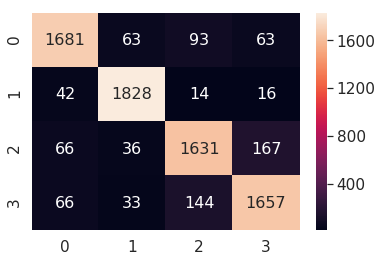

In [214]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l2')
clf.fit(train_data,df_train_label)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(df_test_label, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(df_test_label, y_pred, average = 'micro')))
print("Recall on test set: %0.3f"%(recall_score(df_test_label, y_pred, average = 'micro')))
print("F1-Score on test set: %0.3f"%(f1_score(df_test_label, y_pred,  average = 'micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n")
df_cm = pd.DataFrame(confusion_matrix(df_test_label, y_pred), range(4),range(4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


## TF-IDF

In [215]:
#Vectorizing the description
tfidf_des = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 5000)
tfidf_des_train= tfidf_des.fit_transform(preprocessed_description)
#Normalize
tfidf_des_train = preprocessing.normalize(tfidf_des_train)

tfidf_des_test= tfidf_des.transform(preprocessed_description_test)
#Normalize
tfidf_des_test = preprocessing.normalize(tfidf_des_test)

#Vectorizing the Headline
tfidf_head = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidf_head_train = tfidf_head.fit_transform(preprocessed_headline)
#Normalize
tfidf_head_train = preprocessing.normalize(tfidf_head_train)

tfidf_head_test = tfidf_head.transform(preprocessed_headline_test)
#Normalize
tfidf_head_test = preprocessing.normalize(tfidf_head_test)



In [216]:
train_data = tfidf_head_train + tfidf_des_train
print(train_data.shape)
test_data = tfidf_head_test + tfidf_des_test
print(test_data.shape)

(120000, 5000)
(7600, 5000)


In [217]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
kf = KFold(n_splits=3) #For k fold splitting
gsv = RandomizedSearchCV(clf,param_grid,cv= kf,verbose=1, n_jobs = -1)
gsv.fit(train_data,df_train_label)
#savetofile(gsv,"Log Reg/gsv_tf_idf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 1}
Best Accuracy: 87.95%


Accuracy on test set: 89.526%
Precision on test set: 0.895
Recall on test set: 0.895
F1-Score on test set: 0.895
Non Zero weights: 12601
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



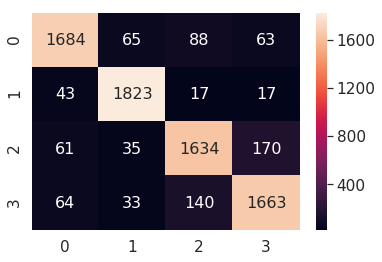

In [221]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(train_data,df_train_label)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(df_test_label, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(df_test_label, y_pred, average = 'micro')))
print("Recall on test set: %0.3f"%(recall_score(df_test_label, y_pred, average = 'micro')))
print("F1-Score on test set: %0.3f"%(f1_score(df_test_label, y_pred,  average = 'micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(df_test_label, y_pred), range(4),range(4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


## Word2Vec

In [222]:
# Train your own Word2Vec model using your own text corpus
list_of_description=[]
for sentence in preprocessed_description:
    list_of_description.append(sentence.split())
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_description,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#Train your own Word2Vec model on test set
list_of_description_test = []
for sentence in preprocessed_description_test:
    list_of_description_test.append(sentence.split())

w2v_model=Word2Vec(list_of_description_test,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#Train your own Word2Vec on train set headline
list_of_headline=[]
for sentence in preprocessed_headline:
    list_of_headline.append(sentence.split())
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_headline,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#Train your own Word2Vec on test set headline
list_of_headline_test=[]
for sentence in preprocessed_headline_test:
    list_of_headline_test.append(sentence.split())
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_headline_test,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

##  Converting text into vectors using wAvg W2V, TFIDF-W2V

In [220]:
# average Word2Vec
# compute average word2vec for each description.
sent_vectors = []; # the avg-w2v for each description is stored in this list
for sent in tqdm(list_of_description): # for each description
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the description
    for word in sent: # for each word in a description
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    

sent_vectors_head = []; # the avg-w2v for each headline is stored in this list
for sent in tqdm(list_of_headline): # for each description
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the description
    for word in sent: # for each word in a description
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_head.append(sent_vec)


#Vectorizing the test set
# average Word2Vec
# compute average word2vec for each description.
sent_vectors_test = []; # the avg-w2v for each description is stored in this list
for sent in tqdm(list_of_description_test): # for each description
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the description
    for word in sent: # for each word in a description
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)


sent_vectors_head_test = []; # the avg-w2v for each headline is stored in this list
for sent in tqdm(list_of_headline_test): # for each description
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the description
    for word in sent: # for each word in a description
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_head_test.append(sent_vec)



 16%|█▌        | 19466/120000 [00:14<01:20, 1247.00it/s]


 32%|███▏      | 38941/120000 [00:30<01:03, 1271.54it/s]


 48%|████▊     | 58012/120000 [00:45<00:55, 1115.39it/s]


 65%|██████▍   | 77515/120000 [01:00<00:34, 1217.34it/s]


 82%|████████▏ | 98265/120000 [01:15<00:15, 1405.87it/s]


 98%|█████████▊| 117954/120000 [01:30<00:01, 1160.20it/s]


 56%|█████▌    | 67449/120000 [00:13<00:10, 5149.91it/s]


 75%|███████▍  | 5671/7600 [00:04<00:01, 1308.34it/s]


100%|██████████| 7600/7600 [00:01<00:00, 5055.98it/s]

In [223]:
train_data = sent_vectors
test_data = sent_vectors_test

In [224]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
kf = KFold(n_splits=3) #For k fold splitting
gsv = RandomizedSearchCV(clf,param_grid,cv= kf,verbose=1)
gsv.fit(train_data,df_train_label)
#savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 500}
Best Accuracy: 52.44%


Accuracy on test set: 52.421%
Precision on test set: 0.524
Recall on test set: 0.524
F1-Score on test set: 0.524
Non Zero weights: 170
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



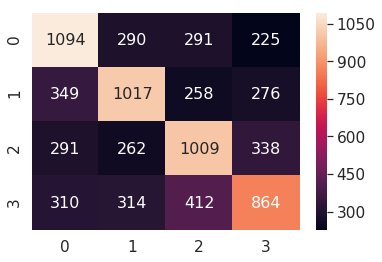

In [225]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(train_data,df_train_label)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(df_test_label, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(df_test_label, y_pred, average = 'micro')))
print("Recall on test set: %0.3f"%(recall_score(df_test_label, y_pred, average = 'micro')))
print("F1-Score on test set: %0.3f"%(f1_score(df_test_label, y_pred,  average = 'micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(df_test_label, y_pred), range(4),range(4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

AvgW2V tends to perforem badly, this is becasue of the feature selection. In which we have only considered the News Description.

## TF-IDF weighted W2v
### (Was taking a lot of time to run)

In [ ]:
# #Vectorizing description
# model = TfidfVectorizer()
# model.fit(preprocessed_description)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentence): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

**Out of all the models TfIdf tend to perform the best. Lets find out the top features responsible for the classification of the data in the 4 classes.**

In [228]:
class_labels=clf.classes_ 
class_labels

array([1, 2, 3, 4])

In [230]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(tfidf_des, clf, class_labels)

1: abuse action abducted according report acquired ability adam able acquiring accident
2: acknowledged add adding across account added additional abuse aboard action
3: according new accept aaron across account abroad acquiring ac accepted abu musab
4: ace accused access abuja abandoned address according study ability addition activities


For further model interpretability pertubation test can be done to check whether the features are collinear or not.